<a href="https://colab.research.google.com/github/ishwarraja/SOAI-ERAV2/blob/main/S9/DP/modular/S9_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [22]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [23]:
'''
class Cifar10SearchDataset(datasets.CIFAR10):
    def __init__(self, root="./data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
])'''


class Cifar10SearchDataset(datasets.CIFAR10):
    def __init__(self, root="~/data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, label

In [24]:
# Create dataset instances
train = Cifar10SearchDataset(root='./data', train=True,download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


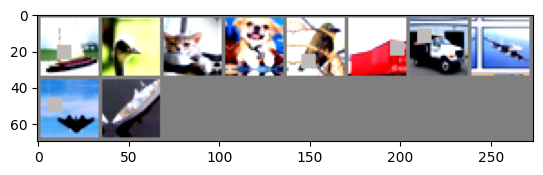

ship  bird  cat   dog   bird  truck truck plane plane ship 


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:10]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))

In [27]:
from model import Net,train,test
from utils import GetCorrectPredCount,return_dataset_images

In [28]:
from torchSummary import summaryparams

summaryparams()
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print(device)
# model = Net(10).to(device)
# summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
            Conv2d-2           [-1, 32, 32, 32]              96
              ReLU-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
           Dropout-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]             288
            Conv2d-7           [-1, 64, 32, 32]           2,048
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 32, 16, 16]          18,432
           Conv2d-12           [-1, 32, 16, 16]             288
           Conv2d-13           [-1, 64, 16, 16]           2,048
             ReLU-14           [-1

In [29]:
from torch.optim.lr_scheduler import StepLR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.7386842966079712 Batch_id=97 Accuracy=26.80: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 1.6569, Accuracy: 3618/10000 (36.18%)

EPOCH: 1


Loss=1.479202151298523 Batch_id=97 Accuracy=39.79: 100%|██████████| 98/98 [00:15<00:00,  6.53it/s]



Test set: Average loss: 1.4424, Accuracy: 4643/10000 (46.43%)

EPOCH: 2


Loss=1.3363432884216309 Batch_id=97 Accuracy=46.47: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]



Test set: Average loss: 1.3119, Accuracy: 5214/10000 (52.14%)

EPOCH: 3


Loss=1.2666864395141602 Batch_id=97 Accuracy=50.67: 100%|██████████| 98/98 [00:14<00:00,  6.79it/s]



Test set: Average loss: 1.2119, Accuracy: 5610/10000 (56.10%)

EPOCH: 4


Loss=1.1740487813949585 Batch_id=97 Accuracy=54.17: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]



Test set: Average loss: 1.1264, Accuracy: 5922/10000 (59.22%)

EPOCH: 5


Loss=1.2216792106628418 Batch_id=97 Accuracy=56.29: 100%|██████████| 98/98 [00:15<00:00,  6.34it/s]



Test set: Average loss: 1.0745, Accuracy: 6087/10000 (60.87%)

EPOCH: 6


Loss=1.205606460571289 Batch_id=97 Accuracy=58.14: 100%|██████████| 98/98 [00:14<00:00,  6.76it/s]



Test set: Average loss: 1.0426, Accuracy: 6235/10000 (62.35%)

EPOCH: 7


Loss=1.0251922607421875 Batch_id=97 Accuracy=59.86: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]



Test set: Average loss: 1.0151, Accuracy: 6305/10000 (63.05%)

EPOCH: 8


Loss=1.114076852798462 Batch_id=97 Accuracy=61.20: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]



Test set: Average loss: 0.9506, Accuracy: 6578/10000 (65.78%)

EPOCH: 9


Loss=1.052527666091919 Batch_id=97 Accuracy=62.35: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]



Test set: Average loss: 0.9371, Accuracy: 6668/10000 (66.68%)

EPOCH: 10


Loss=0.9584380388259888 Batch_id=97 Accuracy=63.69: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]



Test set: Average loss: 0.8708, Accuracy: 6869/10000 (68.69%)

EPOCH: 11


Loss=1.0859148502349854 Batch_id=97 Accuracy=64.51: 100%|██████████| 98/98 [00:14<00:00,  6.78it/s]



Test set: Average loss: 0.8651, Accuracy: 6889/10000 (68.89%)

EPOCH: 12


Loss=1.1666508913040161 Batch_id=97 Accuracy=65.37: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]



Test set: Average loss: 0.8395, Accuracy: 6999/10000 (69.99%)

EPOCH: 13


Loss=0.9747994542121887 Batch_id=97 Accuracy=66.31: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]



Test set: Average loss: 0.8291, Accuracy: 7050/10000 (70.50%)

EPOCH: 14


Loss=0.9282408952713013 Batch_id=97 Accuracy=67.25: 100%|██████████| 98/98 [00:15<00:00,  6.49it/s]



Test set: Average loss: 0.8008, Accuracy: 7203/10000 (72.03%)

EPOCH: 15


Loss=0.8472247123718262 Batch_id=97 Accuracy=67.88: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]



Test set: Average loss: 0.7804, Accuracy: 7278/10000 (72.78%)

EPOCH: 16


Loss=0.9030641913414001 Batch_id=97 Accuracy=68.34: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]



Test set: Average loss: 0.7766, Accuracy: 7269/10000 (72.69%)

EPOCH: 17


Loss=0.7567102313041687 Batch_id=97 Accuracy=69.06: 100%|██████████| 98/98 [00:14<00:00,  6.69it/s]



Test set: Average loss: 0.7517, Accuracy: 7354/10000 (73.54%)

EPOCH: 18


Loss=0.8525043725967407 Batch_id=97 Accuracy=69.37: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]



Test set: Average loss: 0.7256, Accuracy: 7463/10000 (74.63%)

EPOCH: 19


Loss=0.7667160034179688 Batch_id=97 Accuracy=70.05: 100%|██████████| 98/98 [00:15<00:00,  6.53it/s]



Test set: Average loss: 0.7187, Accuracy: 7501/10000 (75.01%)

EPOCH: 20


Loss=0.8957340717315674 Batch_id=97 Accuracy=70.49: 100%|██████████| 98/98 [00:14<00:00,  6.77it/s]



Test set: Average loss: 0.7075, Accuracy: 7491/10000 (74.91%)

EPOCH: 21


Loss=0.7745062708854675 Batch_id=97 Accuracy=70.80: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]



Test set: Average loss: 0.6962, Accuracy: 7531/10000 (75.31%)

EPOCH: 22


Loss=0.9177626371383667 Batch_id=97 Accuracy=71.46: 100%|██████████| 98/98 [00:14<00:00,  6.81it/s]



Test set: Average loss: 0.7172, Accuracy: 7476/10000 (74.76%)

EPOCH: 23


Loss=0.7023910880088806 Batch_id=97 Accuracy=71.85: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]



Test set: Average loss: 0.6916, Accuracy: 7548/10000 (75.48%)

EPOCH: 24


Loss=0.7579720616340637 Batch_id=97 Accuracy=72.47: 100%|██████████| 98/98 [00:14<00:00,  6.68it/s]



Test set: Average loss: 0.6700, Accuracy: 7709/10000 (77.09%)

EPOCH: 25


Loss=0.7687216997146606 Batch_id=97 Accuracy=72.83: 100%|██████████| 98/98 [00:14<00:00,  6.78it/s]



Test set: Average loss: 0.6687, Accuracy: 7650/10000 (76.50%)

EPOCH: 26


Loss=0.7863250970840454 Batch_id=97 Accuracy=72.78: 100%|██████████| 98/98 [00:14<00:00,  6.82it/s]



Test set: Average loss: 0.6534, Accuracy: 7740/10000 (77.40%)

EPOCH: 27


Loss=0.8531856536865234 Batch_id=97 Accuracy=73.02: 100%|██████████| 98/98 [00:14<00:00,  6.78it/s]



Test set: Average loss: 0.6449, Accuracy: 7766/10000 (77.66%)

EPOCH: 28


Loss=0.701980710029602 Batch_id=97 Accuracy=73.35: 100%|██████████| 98/98 [00:15<00:00,  6.45it/s]



Test set: Average loss: 0.6465, Accuracy: 7756/10000 (77.56%)

EPOCH: 29


Loss=0.6657124757766724 Batch_id=97 Accuracy=73.84: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s]



Test set: Average loss: 0.6378, Accuracy: 7812/10000 (78.12%)

EPOCH: 30


Loss=0.743421196937561 Batch_id=97 Accuracy=74.01: 100%|██████████| 98/98 [00:14<00:00,  6.81it/s]



Test set: Average loss: 0.6426, Accuracy: 7803/10000 (78.03%)

EPOCH: 31


Loss=0.6885838508605957 Batch_id=97 Accuracy=74.13: 100%|██████████| 98/98 [00:14<00:00,  6.80it/s]



Test set: Average loss: 0.6175, Accuracy: 7834/10000 (78.34%)

EPOCH: 32


Loss=0.7676208019256592 Batch_id=97 Accuracy=74.39: 100%|██████████| 98/98 [00:14<00:00,  6.77it/s]



Test set: Average loss: 0.6126, Accuracy: 7863/10000 (78.63%)

EPOCH: 33


Loss=0.7859715819358826 Batch_id=97 Accuracy=74.70: 100%|██████████| 98/98 [00:14<00:00,  6.56it/s]



Test set: Average loss: 0.6225, Accuracy: 7857/10000 (78.57%)

EPOCH: 34


Loss=0.66433185338974 Batch_id=97 Accuracy=74.81: 100%|██████████| 98/98 [00:14<00:00,  6.81it/s]



Test set: Average loss: 0.6148, Accuracy: 7898/10000 (78.98%)

EPOCH: 35


Loss=0.626995861530304 Batch_id=97 Accuracy=74.96: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]



Test set: Average loss: 0.5951, Accuracy: 7942/10000 (79.42%)

EPOCH: 36


Loss=0.8184133172035217 Batch_id=97 Accuracy=75.28: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]



Test set: Average loss: 0.5941, Accuracy: 7975/10000 (79.75%)

EPOCH: 37


Loss=0.704452395439148 Batch_id=97 Accuracy=75.69: 100%|██████████| 98/98 [00:15<00:00,  6.52it/s]



Test set: Average loss: 0.5875, Accuracy: 7991/10000 (79.91%)

EPOCH: 38


Loss=0.6702196002006531 Batch_id=97 Accuracy=75.95: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]



Test set: Average loss: 0.6083, Accuracy: 7935/10000 (79.35%)

EPOCH: 39


Loss=0.6800279021263123 Batch_id=97 Accuracy=75.94: 100%|██████████| 98/98 [00:14<00:00,  6.77it/s]



Test set: Average loss: 0.5830, Accuracy: 7991/10000 (79.91%)

EPOCH: 40


Loss=0.6263553500175476 Batch_id=97 Accuracy=76.05: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]



Test set: Average loss: 0.5892, Accuracy: 7982/10000 (79.82%)

EPOCH: 41


Loss=0.709984302520752 Batch_id=97 Accuracy=75.81: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]



Test set: Average loss: 0.5838, Accuracy: 7977/10000 (79.77%)

EPOCH: 42


Loss=0.6793152689933777 Batch_id=97 Accuracy=76.22: 100%|██████████| 98/98 [00:15<00:00,  6.50it/s]



Test set: Average loss: 0.5709, Accuracy: 8046/10000 (80.46%)

EPOCH: 43


Loss=0.6855176091194153 Batch_id=97 Accuracy=76.66: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]



Test set: Average loss: 0.5629, Accuracy: 8058/10000 (80.58%)

EPOCH: 44


Loss=0.6767804622650146 Batch_id=97 Accuracy=76.52: 100%|██████████| 98/98 [00:14<00:00,  6.79it/s]



Test set: Average loss: 0.5659, Accuracy: 8048/10000 (80.48%)

EPOCH: 45


Loss=0.6282498240470886 Batch_id=97 Accuracy=76.60: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]



Test set: Average loss: 0.5641, Accuracy: 8079/10000 (80.79%)

EPOCH: 46


Loss=0.7542341947555542 Batch_id=97 Accuracy=76.70: 100%|██████████| 98/98 [00:14<00:00,  6.76it/s]



Test set: Average loss: 0.5642, Accuracy: 8060/10000 (80.60%)

EPOCH: 47


Loss=0.6904509663581848 Batch_id=97 Accuracy=76.87: 100%|██████████| 98/98 [00:14<00:00,  6.56it/s]



Test set: Average loss: 0.5542, Accuracy: 8102/10000 (81.02%)

EPOCH: 48


Loss=0.800721287727356 Batch_id=97 Accuracy=76.84: 100%|██████████| 98/98 [00:14<00:00,  6.76it/s]



Test set: Average loss: 0.5458, Accuracy: 8137/10000 (81.37%)

EPOCH: 49


Loss=0.5226741433143616 Batch_id=97 Accuracy=77.55: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]



Test set: Average loss: 0.5533, Accuracy: 8098/10000 (80.98%)



In [30]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 17
conv_layers


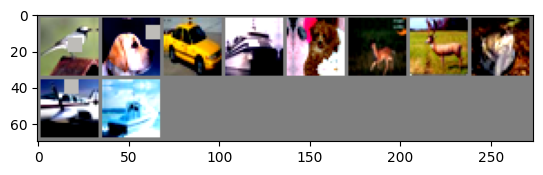

In [31]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

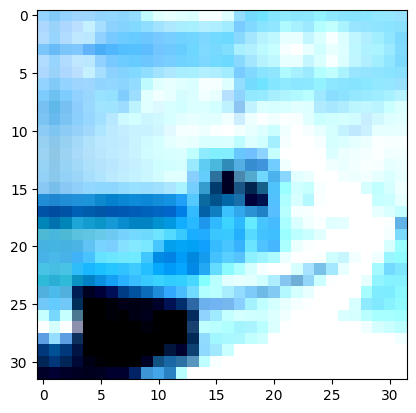

In [32]:
image = images[9]
imshow(image)

In [33]:
image = image.unsqueeze(0)
image = image.to(device)

In [34]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

17
torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 6, 6])
torch.Size([1, 64, 6, 6])
torch.Size([1, 10, 6, 6])


In [35]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(6, 6)
(6, 6)
(6, 6)


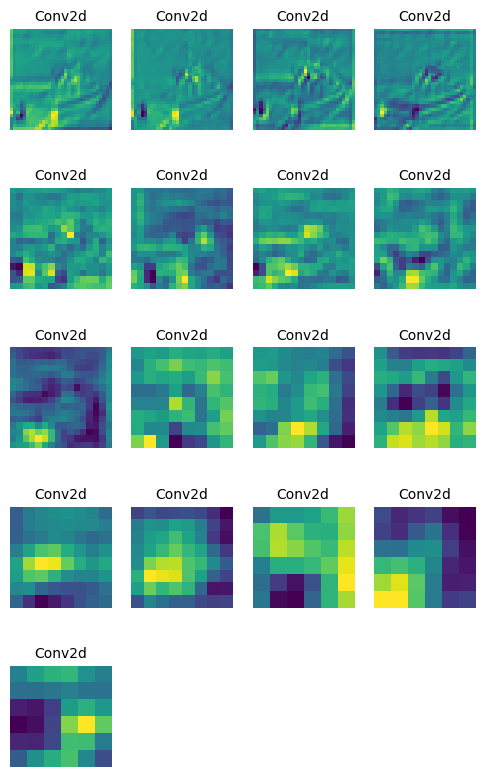

In [36]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

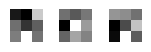

In [37]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()